## *Generating useful features for further analysis on Amazon reviews*

## Introduction

**Business Context.** You are a business consultant with new clients that are interested in analyzing reviews of their products on Amazon (as opposed to Yelp). They want to answer business questions like: "What are the most important factors driving negative reviews?", "Have there been any large changes to customer satisfaction/reviews over time?", etc.

**Analytical Context.** The dataset provided is a large body of reviews related to movies and television left on Amazon between 1996 and 2014. 

We use a dataset of around 37,000 video reviews from Amazon Instant Video and 1,700,000 movie and TV reviews, all obtained from the website: http://jmcauley.ucsd.edu/data/amazon/. Note that there are much larger datasets available at the same site. We can expect better and more consistent results on larger datasets (such as book reviews). Note that these datasets are compressed (gzipped), and they are in [JSON](https://en.wikipedia.org/wiki/JSON) format, with each line representing a review and each line being its own JSON object.

Load Dataset and install 

In [9]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [10]:
!pip install pingouin

In [11]:
%%time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats 
from pingouin import pairwise_tests #this is for performing the pairwise tests
from pingouin import pairwise_ttests #this is for performing the pairwise tests
from sklearn.feature_extraction.text import CountVectorizer
from datetime import datetime
import gzip
import json
import string
import nltk # imports the natural language toolkit
import plotly
from nltk.corpus import stopwords
%matplotlib inline
nltk.download('punkt')

# We won't use this one this time
# we can tell pandas that our file is in gzip format and it will handle the decompression for us
# we also use `lines=True` to indicate that each line of the file is its own JSON object
# instant_video = pd.read_json("reviews_Amazon_Instant_Video_5.json.gz", lines=True, compression='gzip')


# ----------
# The Movies and TV file is very big. If you have problems loading it, you can load only the first 
# 100,000 reviews by using 'chunksize' (uncomment the line with 'chunksize' and comment out the line 
# after that which loads the entire file into `movies_tv`). All of the analysis can be 
# done in the same way using only the subset of reviews but some of the results might be different from the examples.
# ----------
movies_tv = next(pd.read_json("Movies_and_TV_5.json", lines=True, chunksize=100000))
#movies_tv = pd.read_json("reviews_Movies_and_TV_5.json.gz", lines=True, compression='gzip')

/Users/jacobsilva/anaconda3/lib/python3.11/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jacobsilva/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


CPU times: user 3.96 s, sys: 1.34 s, total: 5.3 s
Wall time: 7.37 s


In [12]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/jacobsilva/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [13]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jacobsilva/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Examining the data

We take a look at the first 5 rows of each dataset to see what attributes are available. These are

* **reviewerID:** A unique ID to identify the author of the review.
* **asin:** The ["Amazon Standard Identification Number"](https://www.amazon.com/gp/seller/asin-upc-isbn-info.html) which provides more information about the exact product and version.
* **reviewerName:** The username chosen by the reviewer.
* **helpful:** A record of how many users indicated that the review was helpful/not helpful.
* **reviewText:** The full text of the review.
* **overall:** The overall rating (1-5) left by the reviewer.
* **summary:** A short version of the review, used as the title.
* **unixReviewTime:** The date that the review was created, in [Unix Epoch](https://en.wikipedia.org/wiki/Unix_time) format.
* **reviewTime:** A human readable date giving the day, month, and year.
</font>

In [14]:
print(len(movies_tv))
print(movies_tv.head(5))

100000
       reviewerID        asin                         reviewerName helpful  \
0   ADZPIG9QOCDG5  0005019281  Alice L. Larson "alice-loves-books"  [0, 0]   
1  A35947ZP82G7JH  0005019281                        Amarah Strack  [0, 0]   
2  A3UORV8A9D5L2E  0005019281                      Amazon Customer  [0, 0]   
3  A1VKW06X1O2X7V  0005019281           Amazon Customer "Softmill"  [0, 0]   
4  A3R27T4HADWFFJ  0005019281                                 BABE  [0, 0]   

                                          reviewText  overall  \
0  This is a charming version of the classic Dick...        4   
1  It was good but not as emotionally moving as t...        3   
2  Don't get me wrong, Winkler is a wonderful cha...        3   
3  Henry Winkler is very good in this twist on th...        5   
4  This is one of the best Scrooge movies out.  H...        4   

                                        summary  unixReviewTime   reviewTime  
0                     good version of a classic      1

We notice that `movies_tv` is extremely long with nearly 2 million reviews, and several columns seem uninteresting or hard to work with (e.g. `reviewerID`, `asin`, `reviewername`, `reviewtime`). We drop some information to make some of our later analysis more efficient. We also add a datetime column with Python datetime objects to more easily summarize the data:

In [16]:
movies_tv.head(5)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,ADZPIG9QOCDG5,0005019281,"Alice L. Larson ""alice-loves-books""","[0, 0]",This is a charming version of the classic Dick...,4,good version of a classic,1203984000,"02 26, 2008"
1,A35947ZP82G7JH,0005019281,Amarah Strack,"[0, 0]",It was good but not as emotionally moving as t...,3,Good but not as moving,1388361600,"12 30, 2013"
2,A3UORV8A9D5L2E,0005019281,Amazon Customer,"[0, 0]","Don't get me wrong, Winkler is a wonderful cha...",3,Winkler's Performance was ok at best!,1388361600,"12 30, 2013"
3,A1VKW06X1O2X7V,0005019281,"Amazon Customer ""Softmill""","[0, 0]",Henry Winkler is very good in this twist on th...,5,It's an enjoyable twist on the classic story,1202860800,"02 13, 2008"
4,A3R27T4HADWFFJ,0005019281,BABE,"[0, 0]",This is one of the best Scrooge movies out. H...,4,Best Scrooge yet,1387670400,"12 22, 2013"


In [17]:
#Show columns
movies_tv.columns

Index(['reviewerID', 'asin', 'reviewerName', 'helpful', 'reviewText',
       'overall', 'summary', 'unixReviewTime', 'reviewTime'],
      dtype='object')

In [18]:
#Change reviewTime to datetime format
movies_tv['reviewTime'] = movies_tv['reviewTime'].apply(lambda x: pd.to_datetime(x, format="%m %d, %Y"))

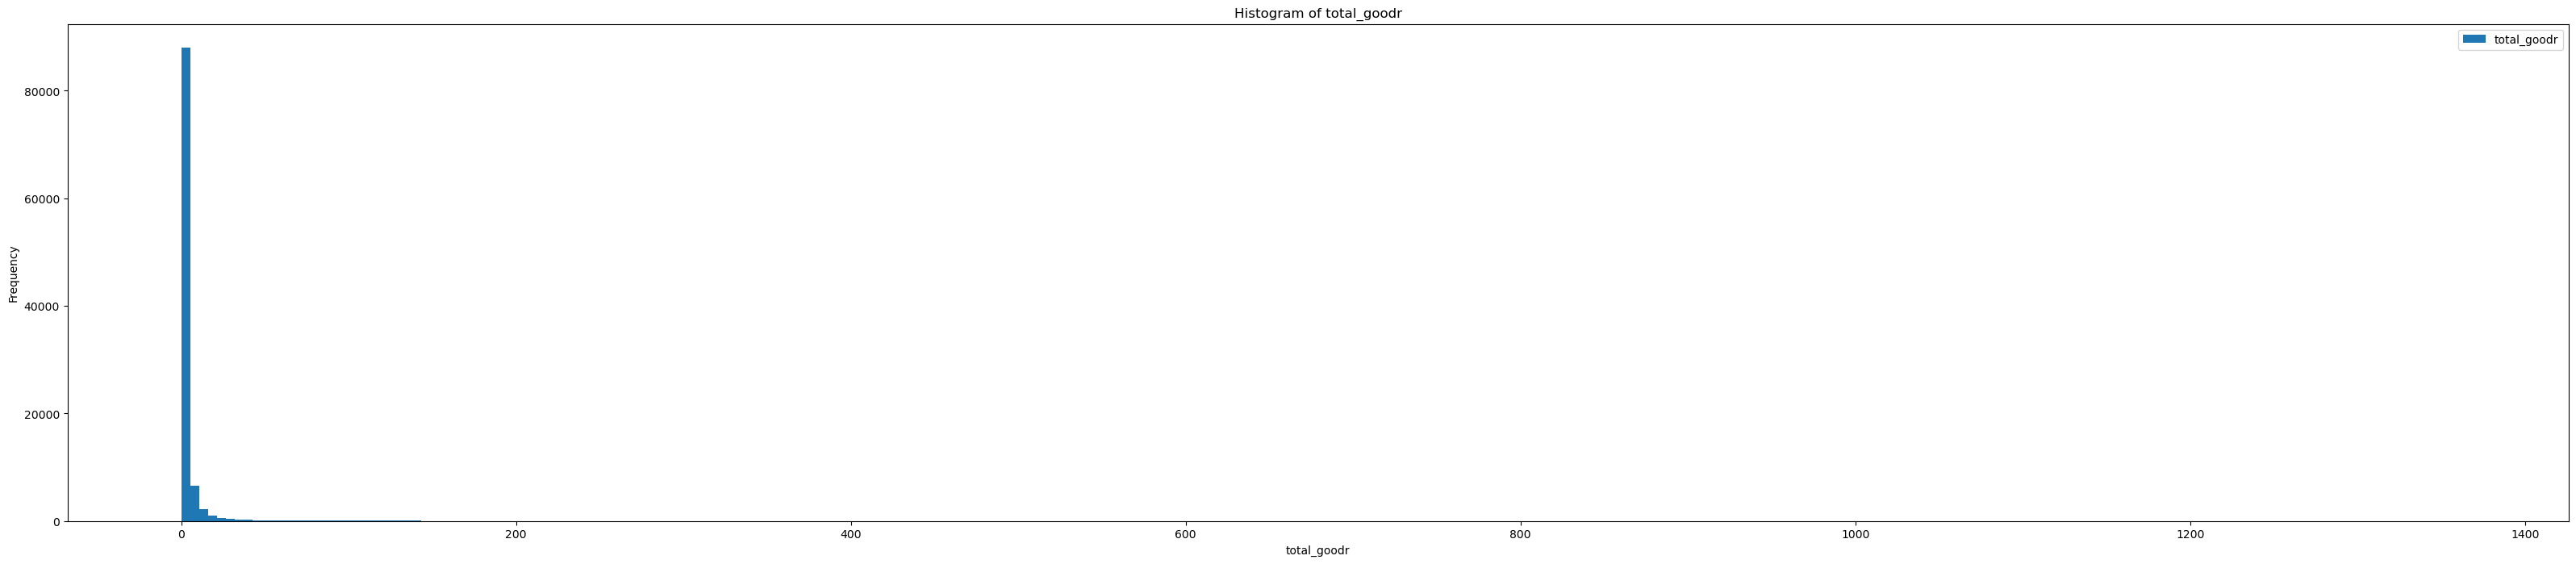

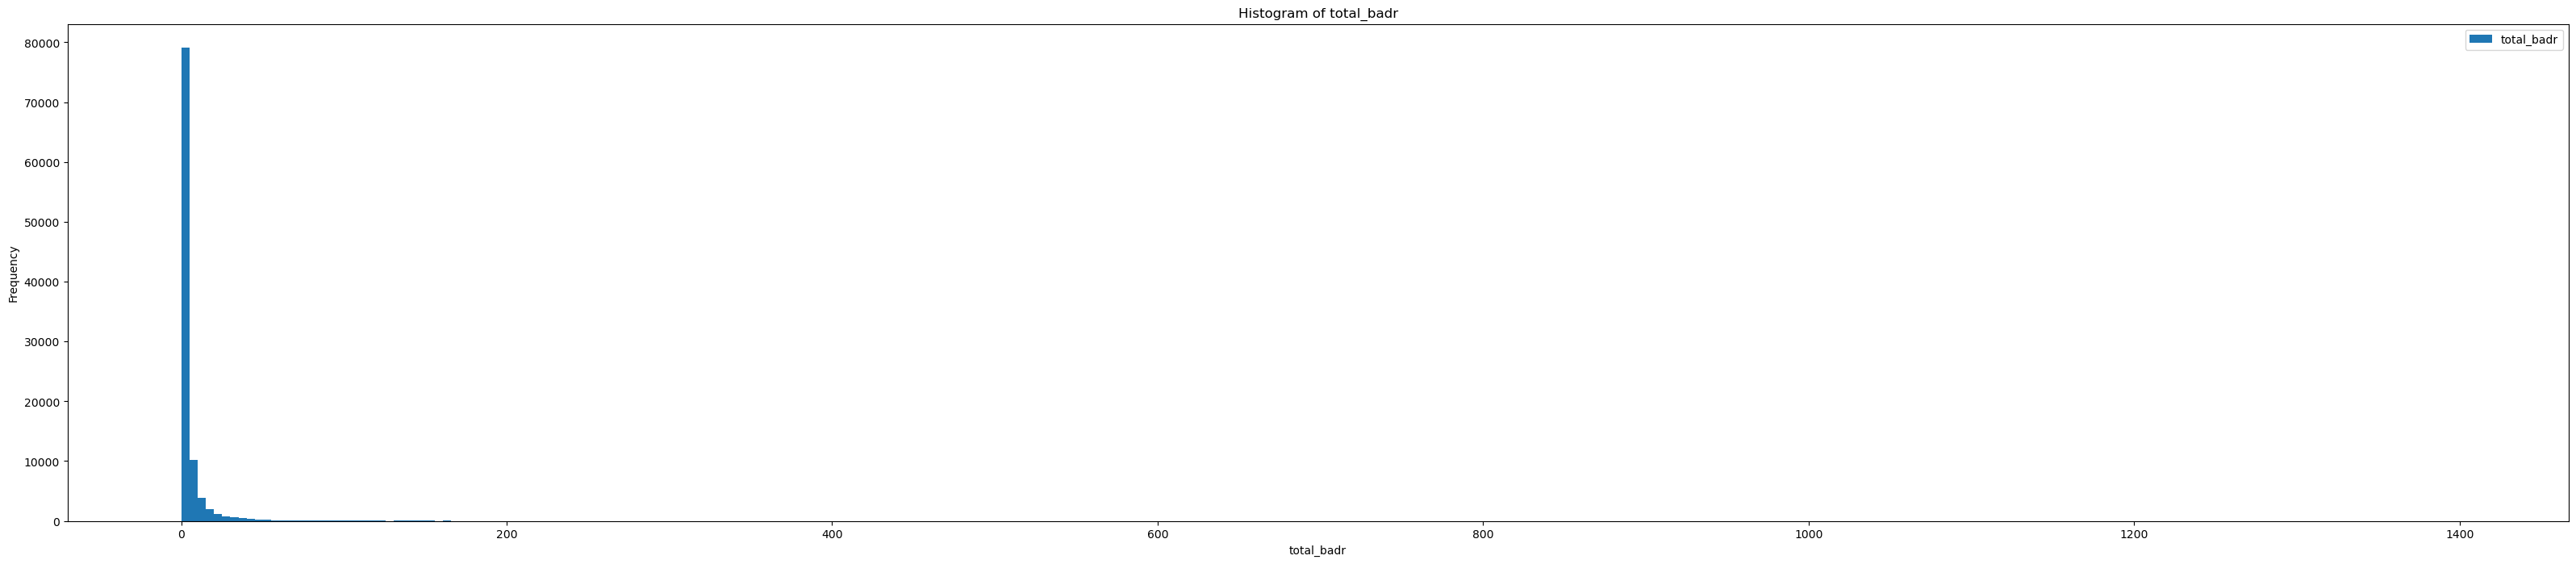

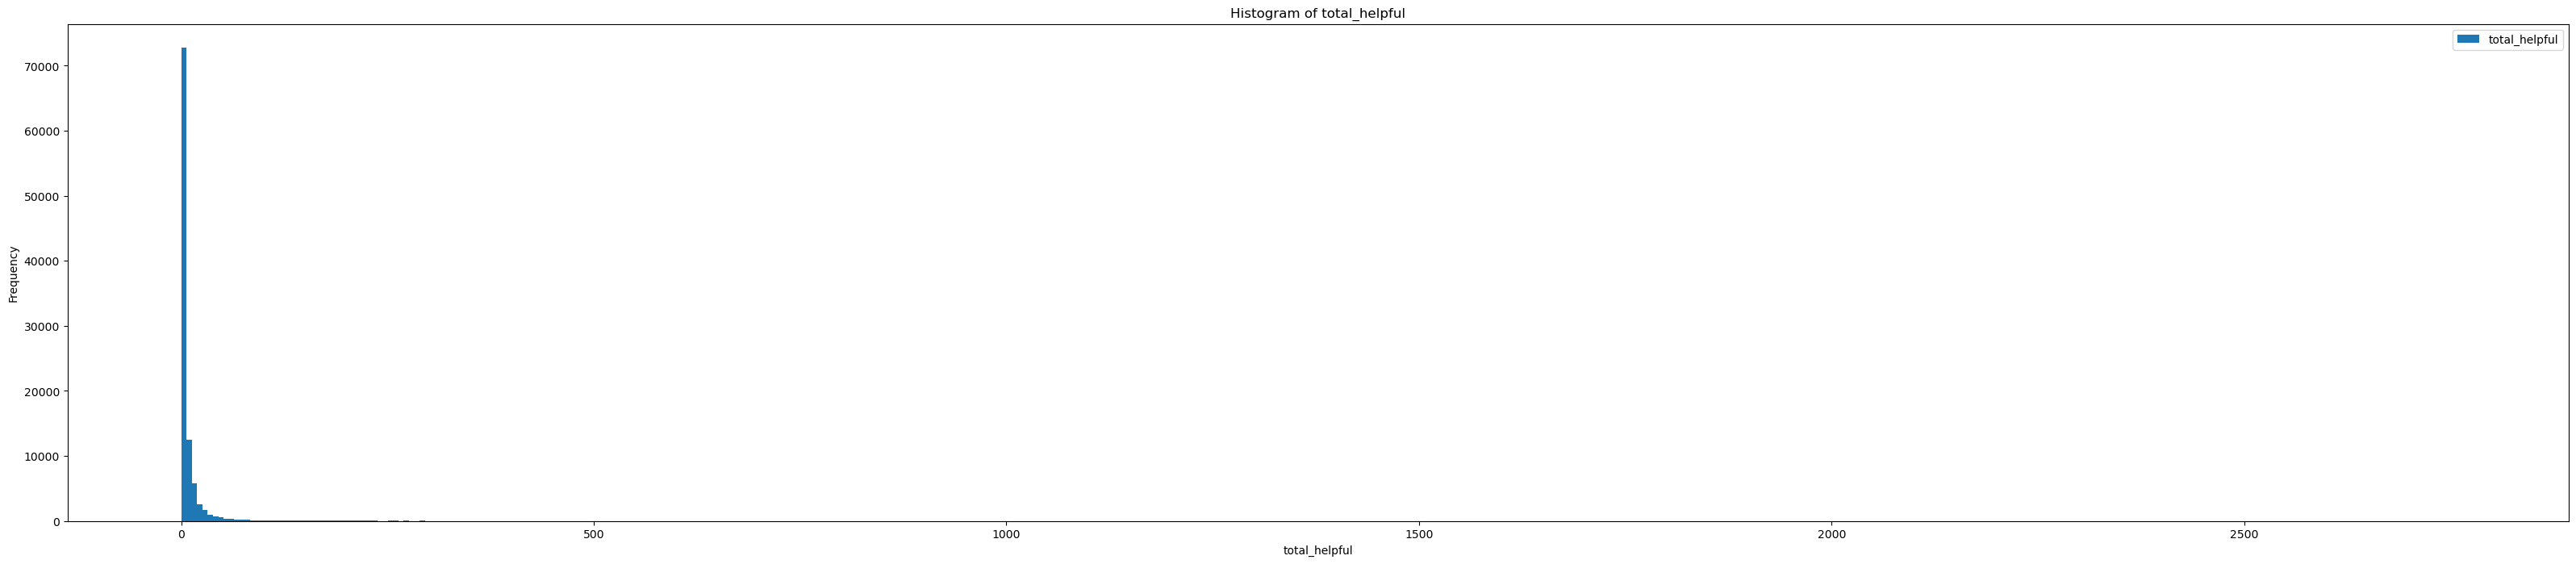

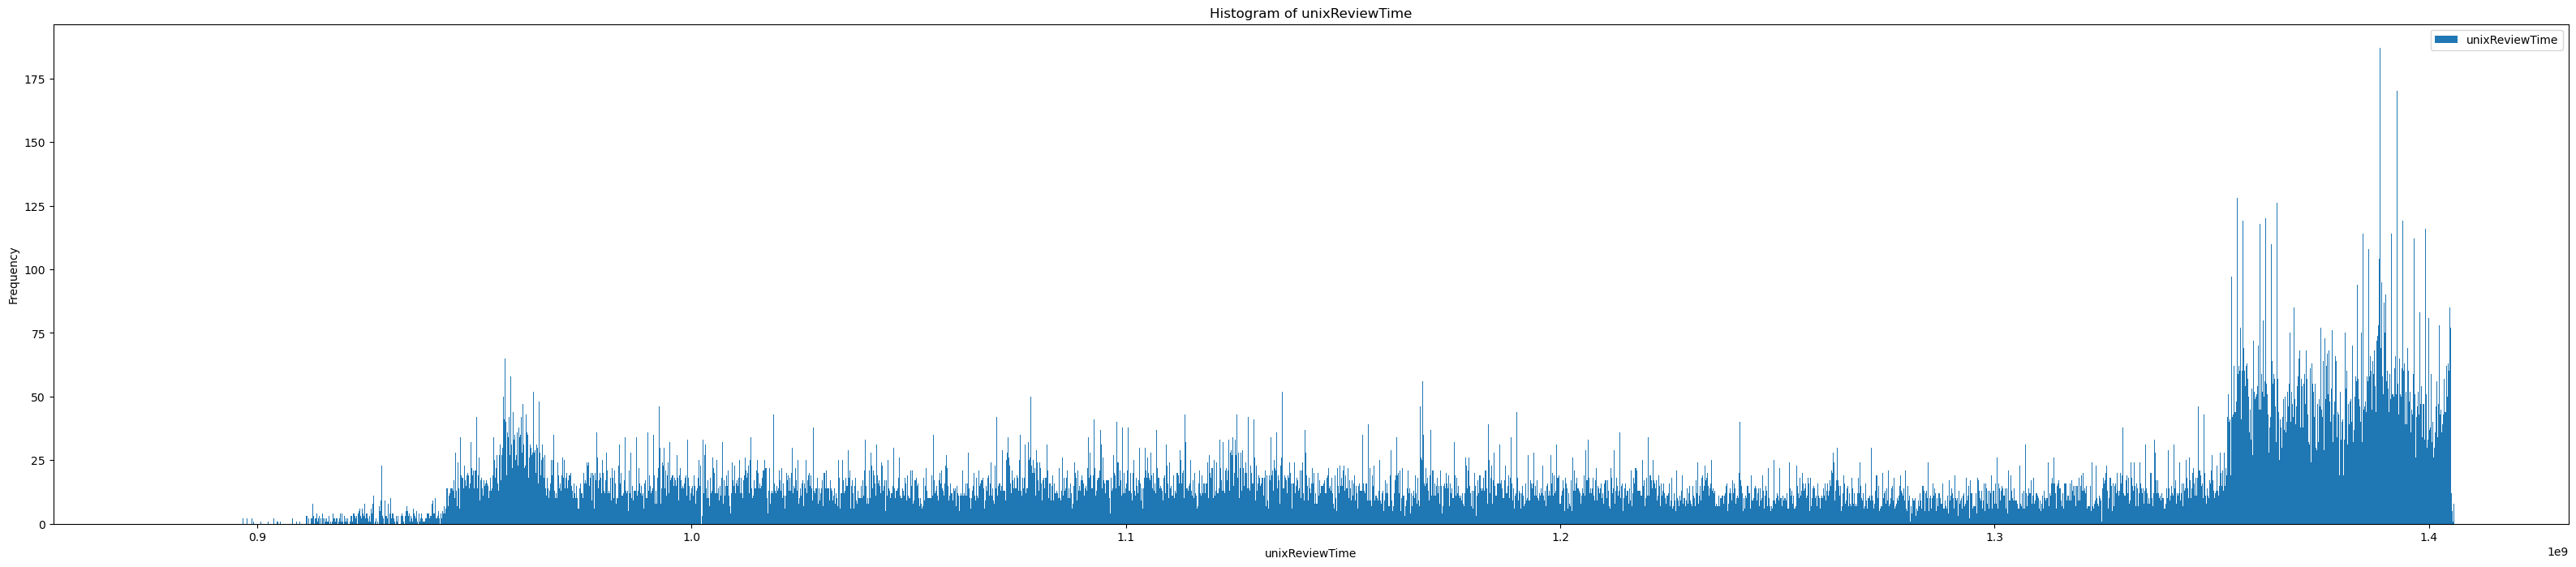

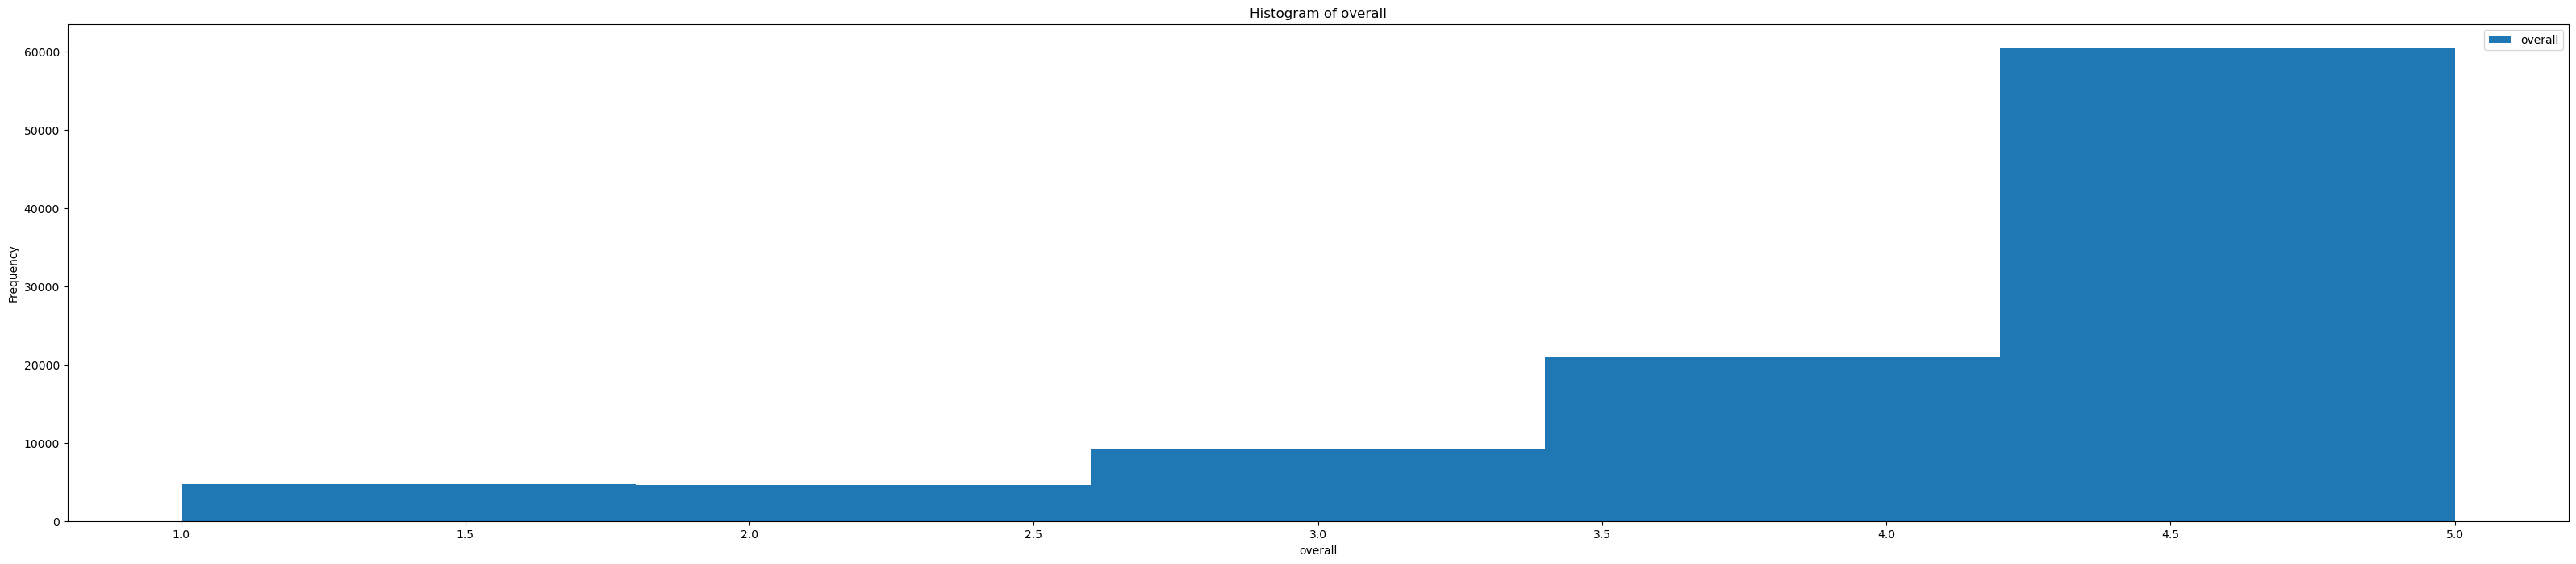

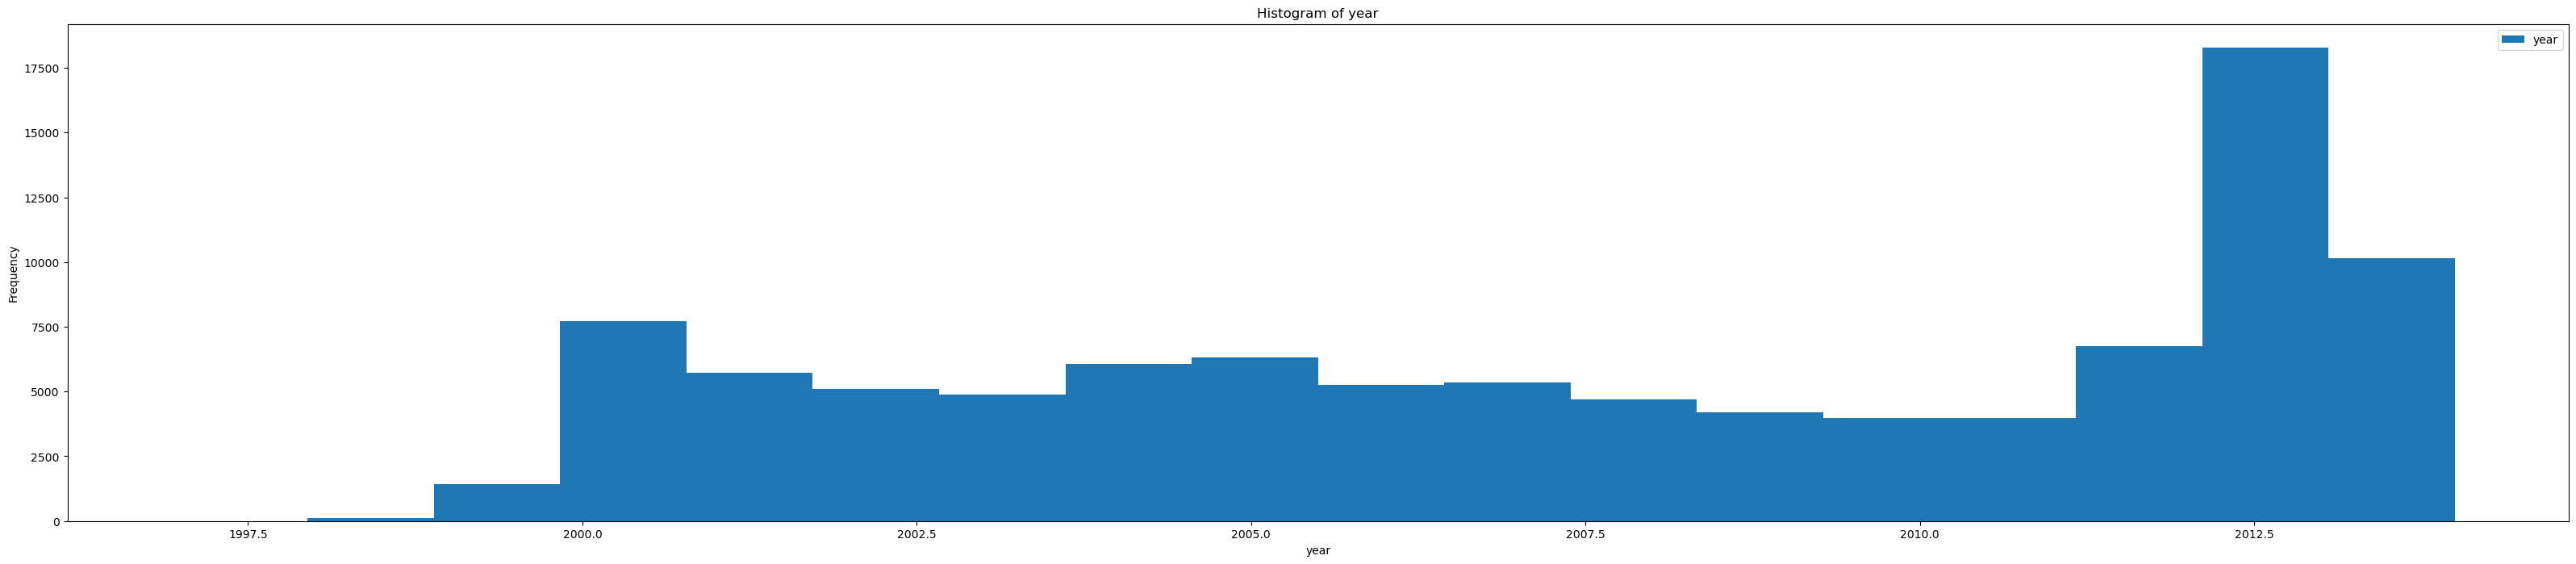

In [19]:
#Function that returns the helpful score
def helpful_goodr_add(listing):
    
    return listing[0]

#Function that returns the non helpful score
def helpful_badr_add(listing):
    
    return listing[1]

#Function that returns the total helpful score
def helpful_total_add(listing):
    
    return listing[0] + listing[1]

#Create new columns for helpful score, non-helpful score, and total helpful score
movies_tv['total_goodr'] = movies_tv['helpful'].apply(helpful_goodr_add)
movies_tv['total_badr'] = movies_tv['helpful'].apply(helpful_badr_add)
movies_tv['total_helpful'] = movies_tv['helpful'].apply(helpful_total_add)

#Create a column that stores year review was written
movies_tv['year'] = movies_tv['reviewTime'].dt.year

#Create a list of numeric columns
numericColumns = ['total_goodr', 'total_badr', 'total_helpful', 'unixReviewTime', 'overall', 'year']

#Loop through each numeric column
for category in numericColumns:
    
    #Get the unique count for the iteration column to use as bins as the bins count are non-static (Always )
    unique_count = movies_tv[category].unique()
    
    #Characteristics of histogram
    plt.figure(figsize=(40, 8))
    plt.hist(movies_tv[category], label = category, orientation = 'vertical', bins = len(unique_count))
    plt.title(f'Histogram of {category}')
    plt.xlabel(category)
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()
    

- Most reviews found to have 0 helpful reviews

- Most reviews were written up in recent years as opposed to past years

- 4.5 to 5.0 star reviews make up the majority of all reviews for movies and shows

- We should consider providing attention to averaging reviews written after 2000 as reviews written prior to 2000 are not frequent enough in the dataframe to provide accurate generalization of analysis'.

[1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010
 2011 2012 2013 2014]


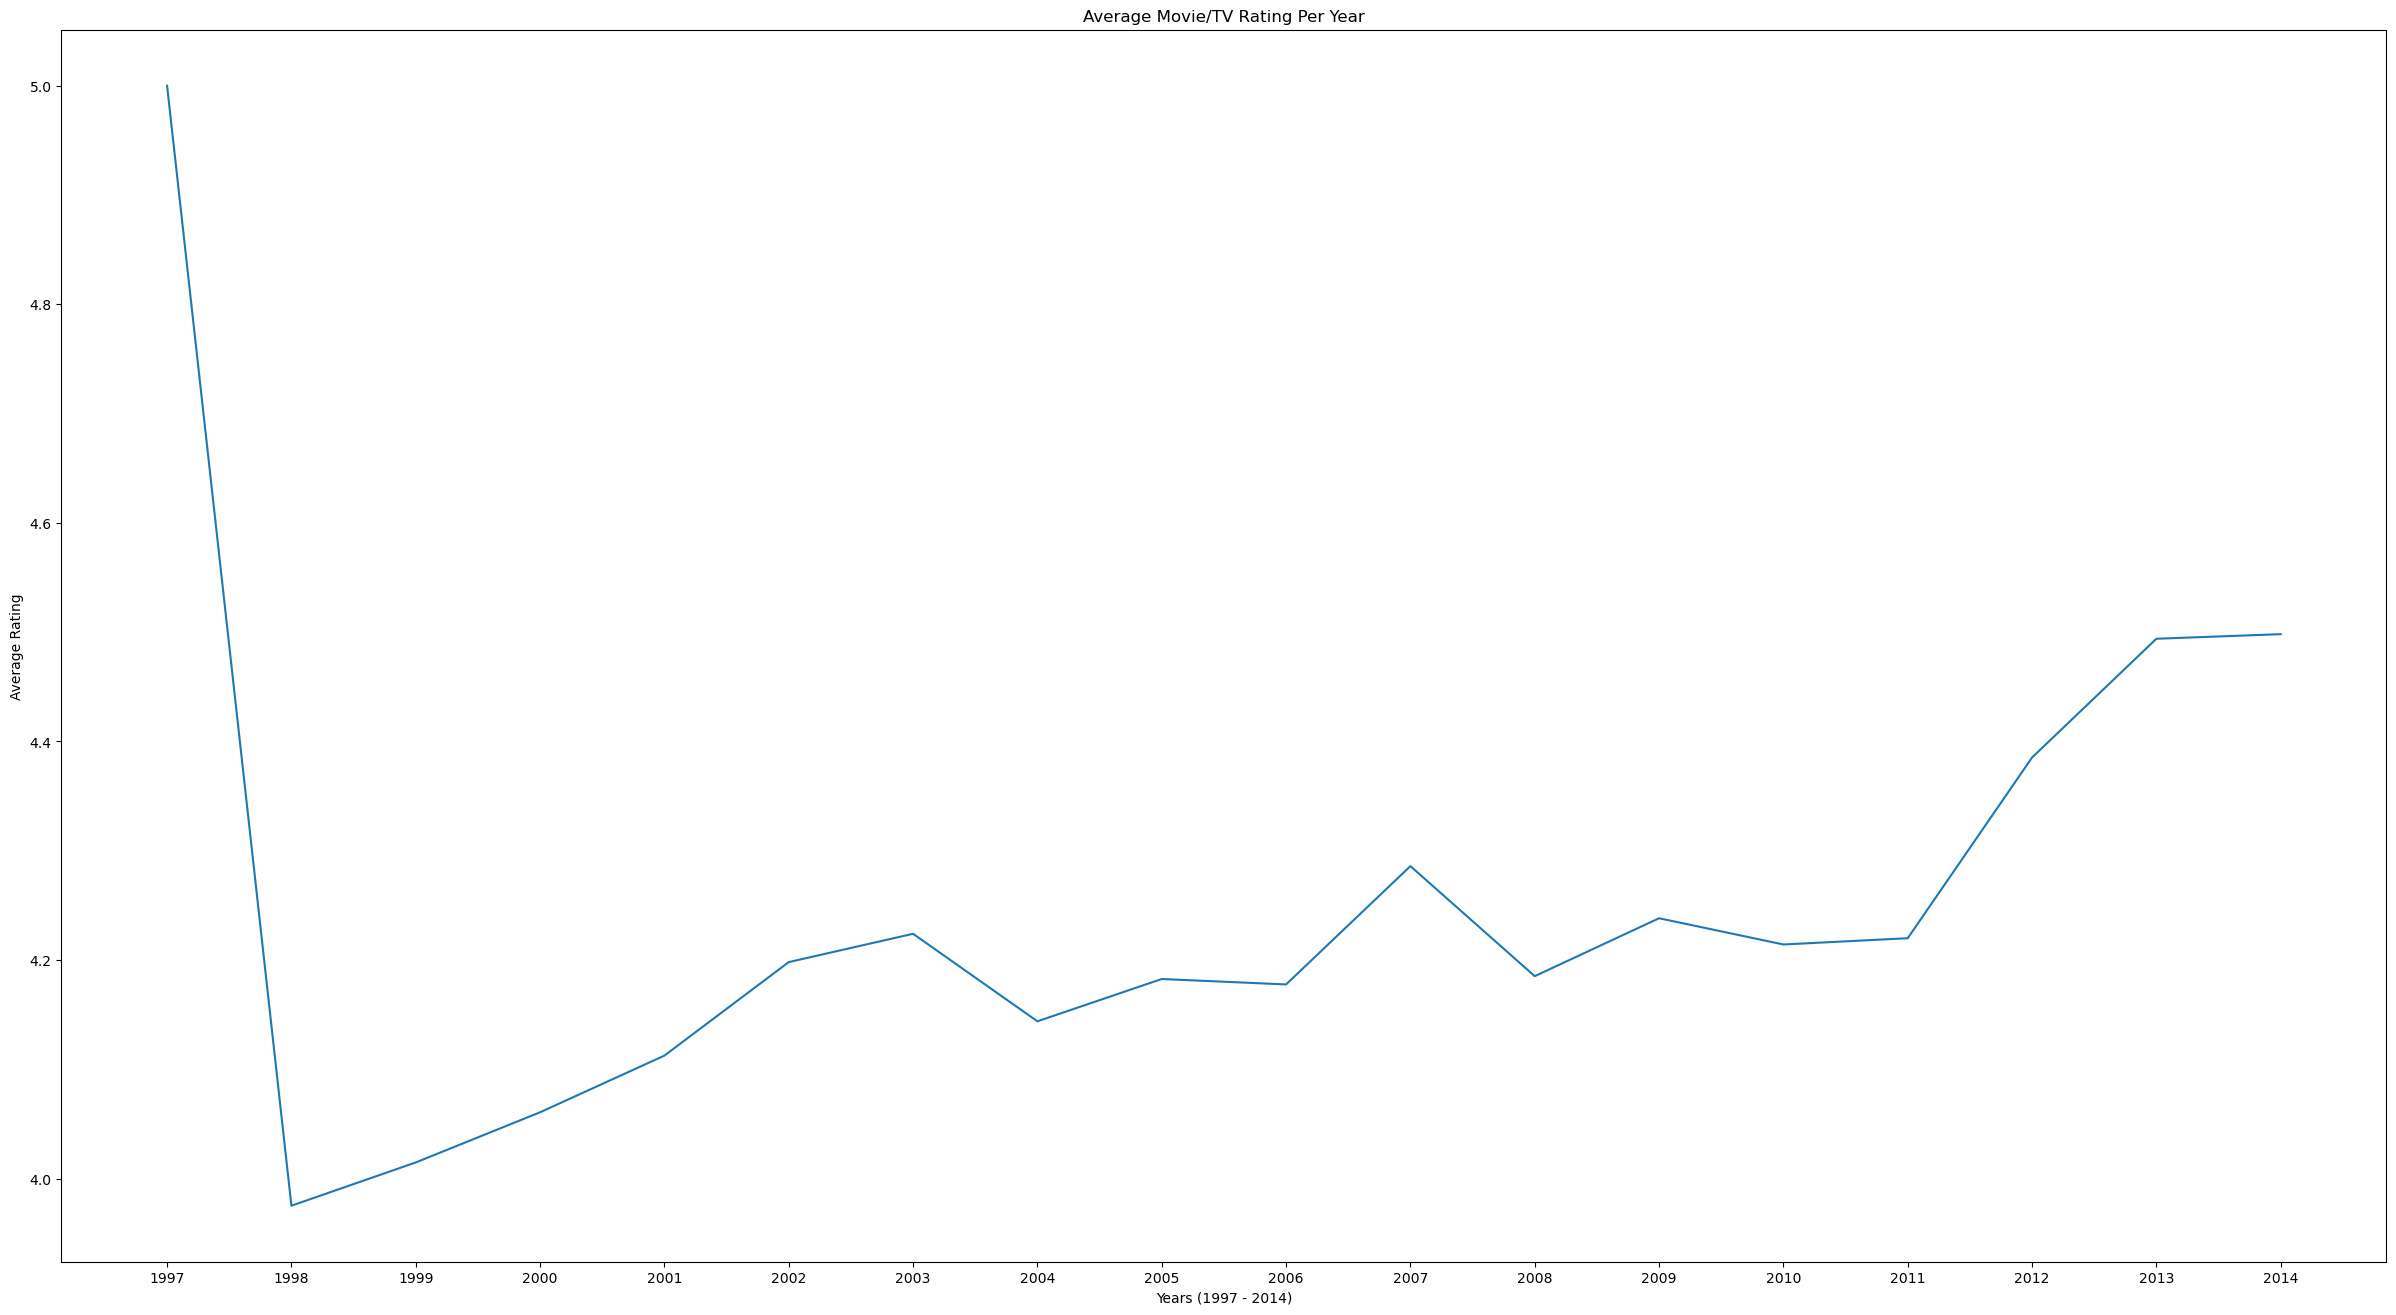

In [20]:
#Create a subdataframe with averages for rating and year
average_rating_py = movies_tv[['overall', 'year']].groupby('year').mean()
average_rating_py.reset_index(inplace=True)

#Check for misnamed year errors
unique_years = average_rating_py['year'].unique()
print(unique_years)

#Characteristics for broken line visualization
plt.figure(figsize=(30, 16))  
plt.plot(average_rating_py['year'], average_rating_py['overall'])
plt.title('Average Movie/TV Rating Per Year')
plt.xlabel('Years (1997 - 2014)')
plt.ylabel('Average Rating')
plt.xticks(average_rating_py['year'])
plt.show()

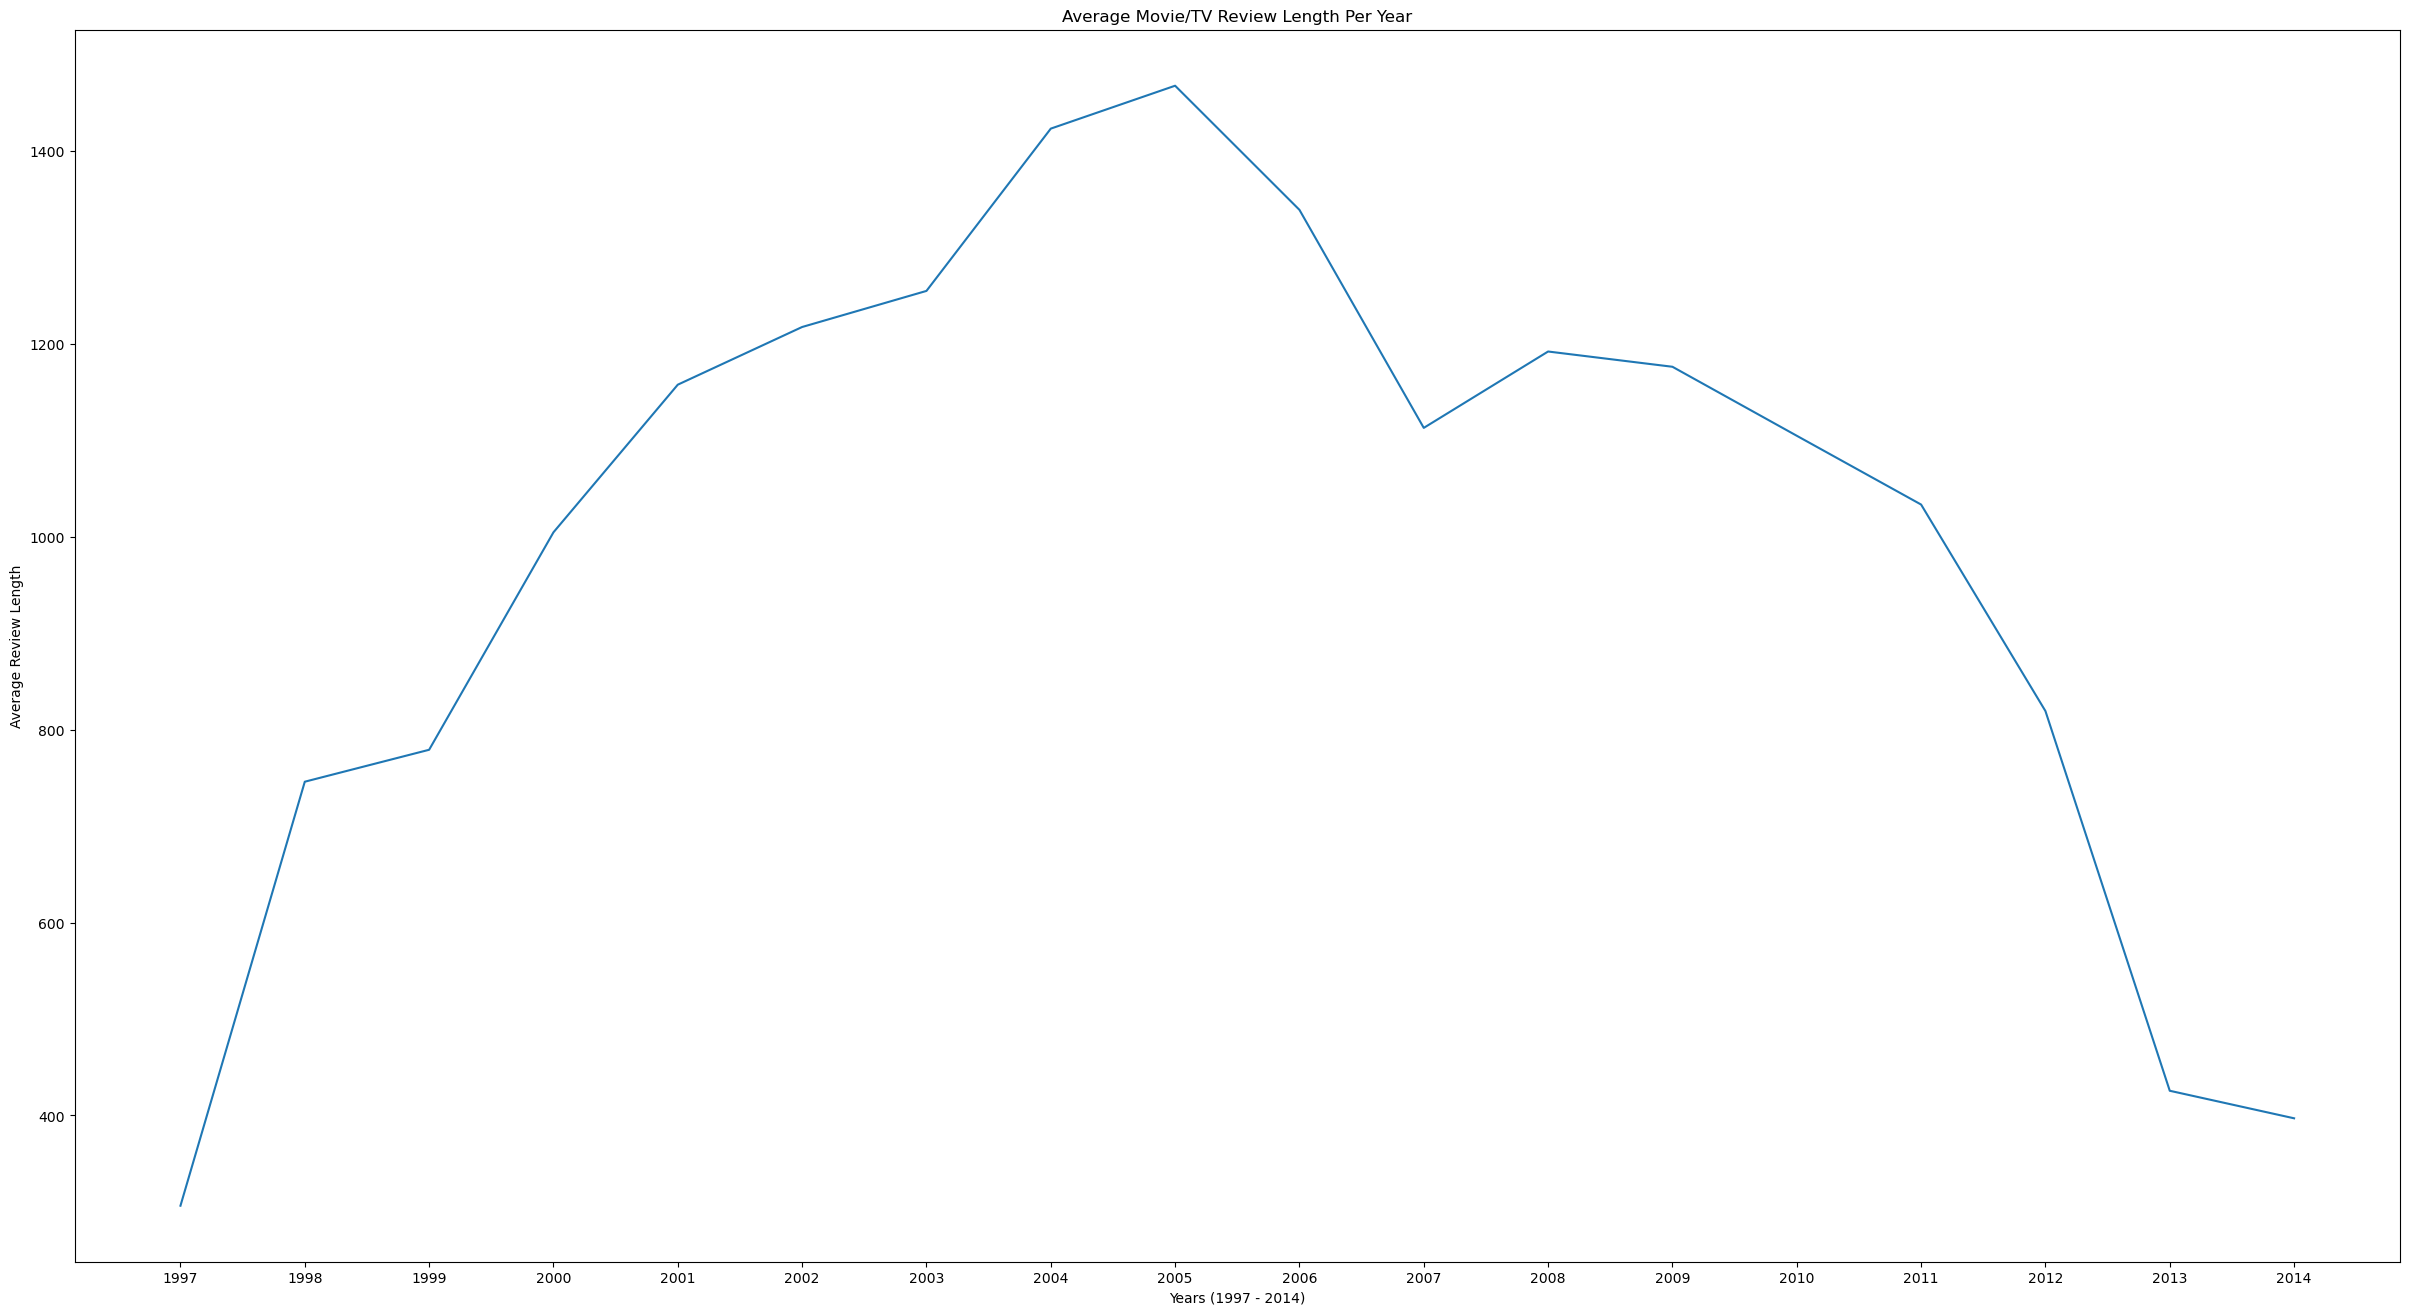

In [21]:
#Create a column that holds the review length
movies_tv['reviewTextLen'] = movies_tv['reviewText'].apply(len)

#Create a subdataframe with averages for review length and year
average_str_len = movies_tv[['reviewTextLen', 'year']].groupby('year').mean()
average_str_len.reset_index(inplace=True)

#Characteristics for broken line visualization
plt.figure(figsize=(30, 16))  
plt.plot(average_rating_py['year'], average_str_len['reviewTextLen'])
plt.title('Average Movie/TV Review Length Per Year')
plt.xlabel('Years (1997 - 2014)')
plt.ylabel('Average Review Length')
plt.xticks(average_rating_py['year'])
plt.show()

- The graph takes an interesting shape where initially the average review length starts low but around 2003 - 2006 (Mid-2000s), the review lengths reach a maximum easily observable through these years.

- After this peak, the average review lengths begin to drop but stay fairly consistant from 2007 to 2011, but drop significantly from 2011 to 2014.

Null Hypothesis - The average ratings of movies and shows in the 90s are fairly equal to the average ratings after the 90s.

Alternative Hypothesis - The average ratings of movies and shows in the 90s are not fairly equal to the average ratings after the 90s.

In [22]:
#Define a function to perform a TTest for 2 different datasets
def performTTest(infoOne, infoTwo):

    #Perform TTest and gather a tStat and pValue between both datasets
    tStat, pVal = stats.ttest_ind(infoOne['overall'], infoTwo['overall'], equal_var = False)
    
    #Print both the tStat and pVal
    print(f"T-Stat: {tStat}\nP-Value: {pVal}")
    
    #If P-Value is less than the threshold, the null hypothesis may be rejected
    if pVal < 0.05:
        print("Null Hypothesis may be rejected. P-Value is less than 5%")
    #Else, the P-Value is greater than the threshold, we cannot reject the null hypothesis
    else:
        print("Null Hypothesis may NOT be rejected. P-Value is greater than 5%.")

#Subdataframe the movies_tv dataframe so it is per decade
movies90s = movies_tv[(movies_tv['year'] >= 1990) & (movies_tv['year'] <= 1999)]
movies2000s = movies_tv[(movies_tv['year'] >= 2000) & (movies_tv['year'] <= 2009)]
movies2010s = movies_tv[(movies_tv['year'] >= 2010) & (movies_tv['year'] <= 2019)]

#Print the comparison between the 1990s vs 2000s
print("\nStatistically Significant 90s vs 2000s?\n")
performTTest(movies90s, movies2000s)

#Print the comparison between the 1990s vs 2010s
print("\nStatistically Significant 90s vs 2010s?\n")
performTTest(movies90s, movies2010s)


Statistically Significant 90s vs 2000s?

T-Stat: -4.8698798086687765
P-Value: 1.2260681926349702e-06
Null Hypothesis may be rejected. P-Value is less than 5%

Statistically Significant 90s vs 2010s?

T-Stat: -12.614225108630656
P-Value: 7.34749788593297e-35
Null Hypothesis may be rejected. P-Value is less than 5%


The tStat represents the standard deviations from sample mean to population mean, in our examples, we see that the first and second t-stats are significantly low. Now although we see that we can reject the null hypothesis being the average ratings of movies in the 90s are equal to those in following decades (Saying that these ratings are statistically significant), it is important to take this fact as with a grain of salt due our small t-value as our sample sizes are not anywhere near one another.

In [23]:
short_movies_tv = movies_tv.head(10000)

In [24]:
#Define function to tokenize, convert to lower case and then remove stop words in a passed in review
def setup_words(review):
    #Tokenize all words in the passed in review
    individ_words = nltk.word_tokenize(review)
    #Convert all words to lowercase
    individ_words = [individ_word.lower() for individ_word in individ_words if individ_word.isalpha()]
    #Set a set of stopwords and create a listing of individual words that do NOT include any values in the stop_words set
    stop_words = set(stopwords.words('english'))
    individ_words = [individ_word for individ_word in individ_words if individ_word not in stop_words]
    return individ_words

#Define function to check frequency of words in passed in reviewwords list and hold the topblank (Number of values)
def check_freq(review_words, topblank):
    #Bind the words frequency to the word itself
    word_appear = nltk.FreqDist(review_words)
    #Subset the topblank num of words and parse as dictionary
    most_words_show = dict(word_appear.most_common(topblank))
    return most_words_show

#Join all reviews together and setup words using the function
all_review = ' '.join(short_movies_tv['reviewText'])
all_review_words = setup_words(all_review)

#Join good reviews (Overall is greater than 3) together and setup words using the function
good_review = ' '.join(short_movies_tv[short_movies_tv['overall'] > 3]['reviewText'])
good_review_words = setup_words(good_review)

#Join bad reviews (Overall is less than 3) together and setup words using the function
bad_review = ' '.join(short_movies_tv[short_movies_tv['overall'] < 3]['reviewText'])
# Tokenize and preprocess words for negative reviews
bad_review_words = setup_words(bad_review)

#Call function to store the top 10 frequent showing words for specific categories
allrd = check_freq(all_review_words, 10)
grd = check_freq(good_review_words, 10)
brd = check_freq(bad_review_words, 10)

#Print top 10 word frequencies for all categories
print("Frequency of All Reviews:")
print(allrd)
print("\nFrequency of Good Reviews:")
print(grd)
print("\nFrequency of Bad Reviews:")
print(brd)

Frequency of All Reviews:
{'movie': 13083, 'film': 10350, 'one': 7784, 'like': 4670, 'great': 4246, 'quot': 4106, 'good': 4105, 'story': 3579, 'would': 3570, 'time': 3356}

Frequency of Good Reviews:
{'movie': 10452, 'film': 8215, 'one': 6433, 'great': 3800, 'like': 3519, 'quot': 3331, 'good': 3212, 'story': 2933, 'time': 2771, 'would': 2569}

Frequency of Bad Reviews:
{'movie': 1343, 'film': 1040, 'one': 654, 'like': 577, 'would': 530, 'jesus': 466, 'quot': 393, 'even': 348, 'see': 333, 'good': 331}


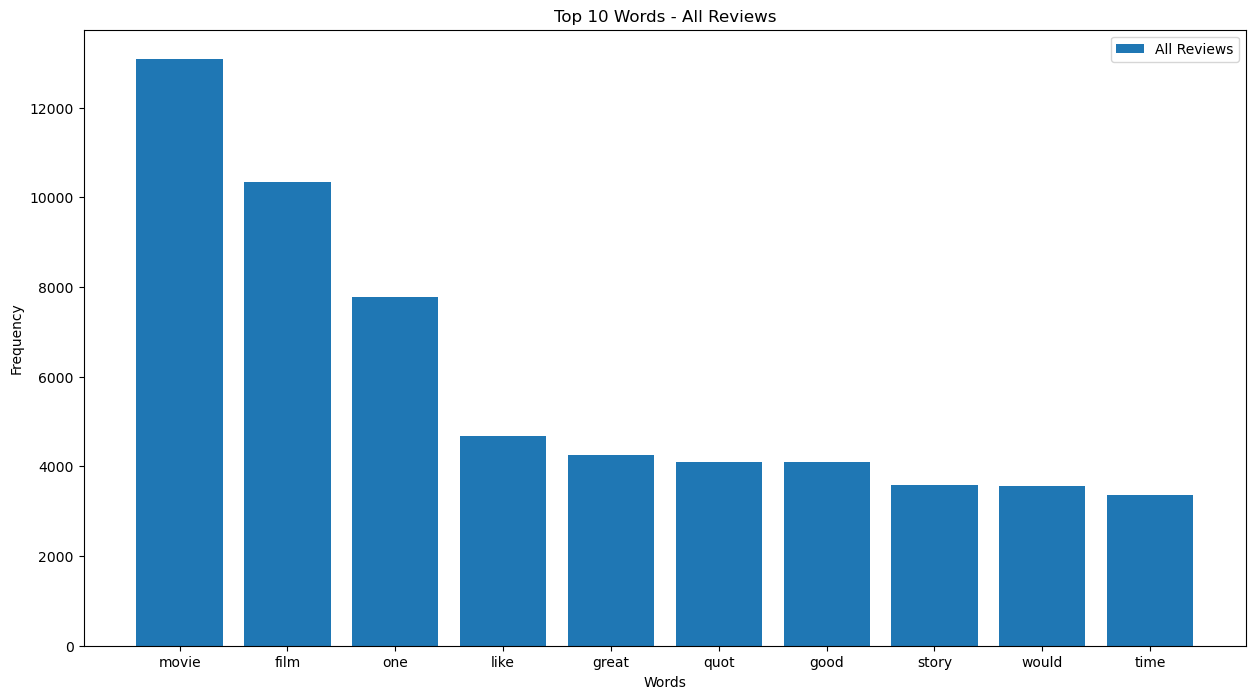

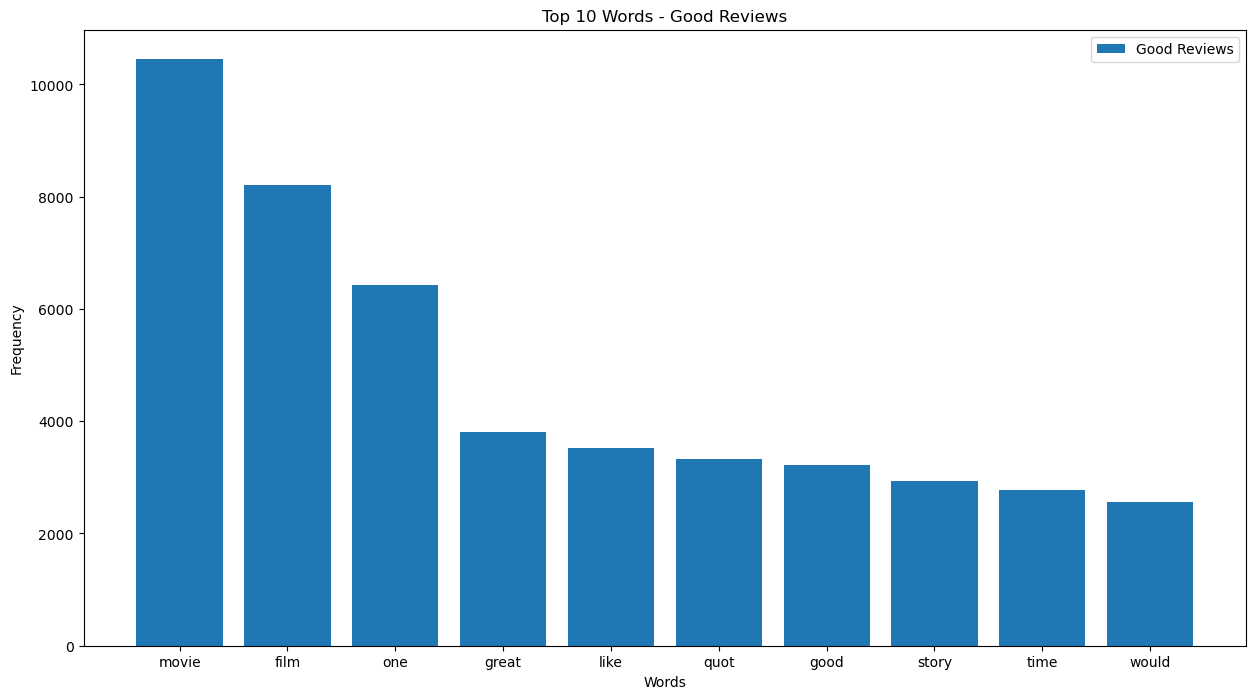

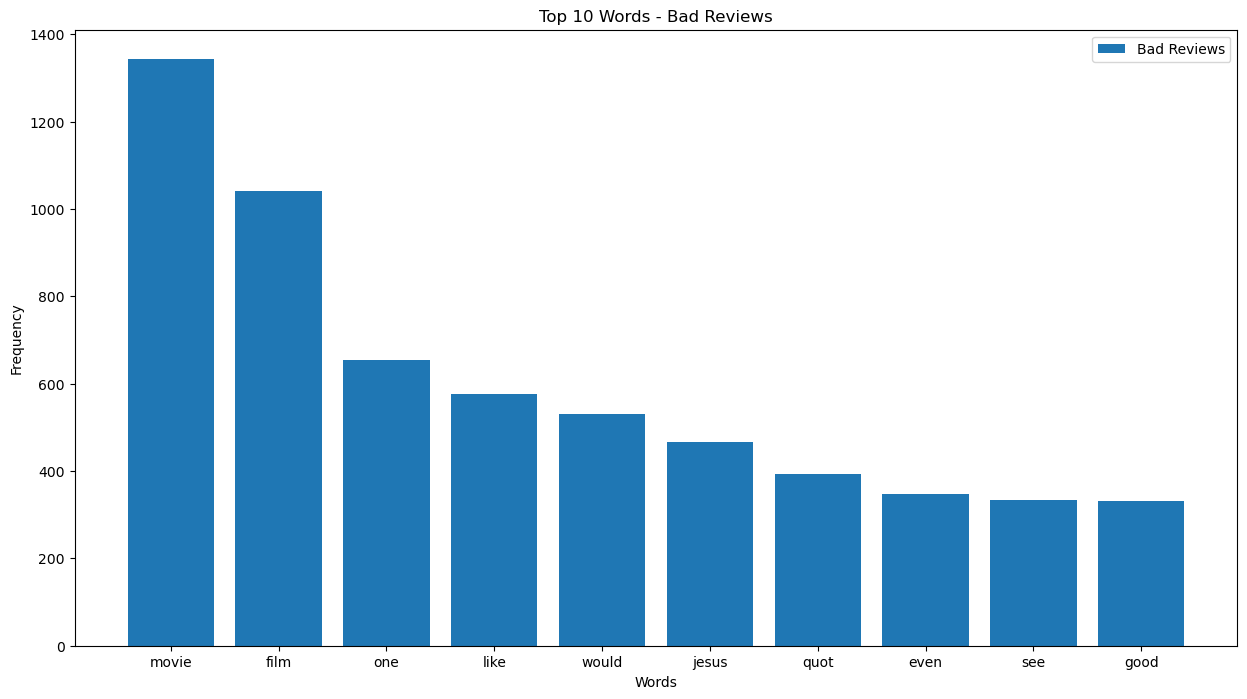

In [16]:
#Create a list of categories and category title
frequency_dicts = [allrd, grd, brd]
review_titles = ['All Reviews', 'Good Reviews', 'Bad Reviews']

#Loop through each category and print a bargraph for word vs frequency using the dictionaries gathered in the previous step
for freq_dict, title in zip(frequency_dicts, review_titles):
    plt.figure(figsize=(15, 8))
    plt.bar(freq_dict.keys(), freq_dict.values(), label=title)
    plt.title(f'Top 10 Words - {title}')
    plt.xlabel("Words")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

It is shocking to see that the most common words that appear in the bad reviews are positive expressive words. Even more-so shockingly, the frequency of words in good reviews are approximately 10x that of the same words in the bad reviews, but this is significant as these same words are the top in the bad reviews. Lastly, it is interesting to see that 7 of the 10 most frequent words that appear in good reviews are also apparent in the bad reviews.

In [25]:
#Define function to get a list of words indicative of a specific catergory of review
def indicative_list(D1=None, D2=None, numTop=None, howIndic=None, sizeAnalyseL1=None, sizeAnalyseL2=None):

    #Create empty list to store the top indicative words
    top_indic_words = []
    
    #Get the frequency distribution of words that we will use for analysis and for comparison
    analyse_listing = list(check_freq(D1, sizeAnalyseL1))
    compare_listing = list(check_freq(D2, sizeAnalyseL2))
    
    #Loop through each word 
    for i in analyse_listing:
        #Check if the individual word from analyse_listing is not in the sublist of the top comparison words, and append to list
        if i not in compare_listing[:howIndic]:
            top_indic_words.append(i)
            
        #Stop the loop if the length of the list is the passed in value (20)
        if len(top_indic_words) == numTop:
            break
        
    return top_indic_words

#Get and store the top 20 negative indicative words 
top_20_indic_bad = indicative_list(D1 = bad_review_words, D2 = good_review_words, numTop = 20, howIndic = len(good_review_words)//4, sizeAnalyseL1 = len(bad_review_words), sizeAnalyseL2 = len(good_review_words))

#Print the indicative bad review words
print(top_20_indic_bad)

['vatican', 'pasolini', 'denier', 'ingram', 'bront', 'yakuza', 'afterglow', 'perverted', 'disrespectful', 'malformed', 'iconography', 'hamburger', 'pronouncing', 'brawl', 'spewing', 'rheinfelden', 'jayston', 'masochistic', 'rubbing', 'cromwell']


Through playing around the howIndic value, or how closely indicitave of bad reviews we want the list of words to be, the larger the value, the more specific the words are to the movie/tv shows plot. In the above list of words where we choose a large howIndic value, being the number of all non-stop words in the good reviews floor divided by 4. With this knowledge, we can assume that the context in which these words are used in reviews are most specific to the movies' or shows plot (Perhaps a more personal connective review to the movie). With an increased howIndic value, we can gain insight as to specific opinions on the movie or shows direction.

In [26]:
v_bad_indices = movies_tv['overall'] < 1.1
v_bad_reviews = movies_tv[v_bad_indices]

RED_START = "\033[91m"
END = "\033[0m"

good_word_bad_review = [rev for rev in v_bad_reviews['reviewText'] if 'good' in rev.lower()]

print(len(good_word_bad_review))
for rev in good_word_bad_review[:50]:
    good_i = rev.lower().index("good")
    # we add Ansi codes to highlight the matches
    print(rev[good_i-50: good_i] + RED_START + rev[good_i:good_i+4] + END + rev[good_i+4:good_i +50])

1266
good, the story was correct, but naked backsides w
good but the scene with Yukon discovering peppermi
th absolutely NO edits whatsoever to the material.Good for us!Edits are for losers!I have spoken.
t least made it about an interesting story with a good plot and character development...i agree with
t everything I've seen thus far does not resemble good cinema in any shape, form, or manner. So, I g
itself is beautifully filmed. The acting is quite good and as a history freak I found it interesting
rtaining) and provides nothing that makes us feel good or is uplifting or is of any benefit, except 
ven if that person is Christ. The flashbacks were good and I'd rather have watched them than watched
to explain what singled out Christ as a symbol of good because a)he is a shallow and poor filmmaker 
 (and no-one could endure the pain).They say it's good to show the extent of the sacrifice that Jesu
good review when it was released, and I went to se
 story that everyone knows and of cor

The word good seems to be used in 2 ways, the first being what the reviewer found to be the aspects of the movie or show that they call to be upsides. Often this comes in the form "The movie portrayed good _____, but ______". The second way is that the word is used to portray the aspects of the film that are "NOT good", often in the form of "______ is not a good _____". The first way is a little bit challenging in driving our analysis by not tackling the negative view head-on, leaving us with unnecessary clutter in our exploratory stage. Although the second way seems to be a much more useful and informative for our analysis, I find it to still to be a roundabout way of coming to understand what drives negative reviews. By identifying some specific negative keywords found in user reviews and pairing it with our original keyword "good", we could gather much more valuable insights as to the elements of set shows or movies that lead audiences provide poor reviews.

In [27]:
#Loop through the top 15 reviews in good_word_bad_review
for review in good_word_bad_review[:15]:

    #Remove all punctuation in review
    review_without_punctuation = ''.join(char if char not in string.punctuation else ' ' for char in review)

    #Tokenize each word in the review and assign each a tag (Word type)
    wrdtoken = nltk.word_tokenize(review_without_punctuation)
    wrdPS = nltk.pos_tag(wrdtoken)

    #Initialize variables to store words as None to avoid errors
    word_af_good = None
    word_af_good_nc = None
    word_bf_good_nc = None

    #Loop through each word storing an index and both the word with its tag
    for listindex, (wrd, PS) in enumerate(wrdPS):
        #If the word is good and is not the last word
        if wrd.lower() == 'good' and listindex < len(wrdPS) - 1:
            
            #Get the word after good and store it as word_af_good
            word_af_good = wrdPS[listindex + 1][0]

            #Loop through words that appear after good
            for afterGood in range(listindex + 1, len(wrdPS)):
                #If the word is a noun or cardinal, store it as word_af_good_nc and break so it is the first occurence
                if wrdPS[afterGood][1] in ['NN', 'NNS', 'NNP', 'NNPS', 'CD']:
                    word_af_good_nc = wrdPS[afterGood][0]
                    break

            #Loop through words that appear before good
            for beforeGood in range(0, listindex):
                
                #If the word is a noun or cardinal, store it as lastNCBefore and dont break so it is the last occurence
                if wrdPS[beforeGood][1] in ['NN', 'NNS', 'NNP', 'NNPS', 'CD']:
                    word_bf_good_nc = wrdPS[beforeGood][0]
                
                #Break only when reaching good as to affirm it is the last word before good
                if wrdPS[beforeGood][0].lower() == 'good':
                    break
    
    #For each review, print the word after good, and the first noun or cardinal after good as well as the last noun or cardinal before good
    print("The first word after good                           :\t", word_af_good)
    print("The first word after good that is a noun or cardinal:\t", word_af_good_nc)
    print("The last word before good that is a noun or cardinal:\t", word_bf_good_nc)
    print("\n")

The first word after good                           :	 the
The first word after good that is a noun or cardinal:	 story
The last word before good that is a noun or cardinal:	 acting


The first word after good                           :	 but
The first word after good that is a noun or cardinal:	 scene
The last word before good that is a noun or cardinal:	 transfer


The first word after good                           :	 for
The first word after good that is a noun or cardinal:	 Edits
The last word before good that is a noun or cardinal:	 material


The first word after good                           :	 plot
The first word after good that is a noun or cardinal:	 plot
The last word before good that is a noun or cardinal:	 story


The first word after good                           :	 cinema
The first word after good that is a noun or cardinal:	 cinema
The last word before good that is a noun or cardinal:	 everything


The first word after good                           :	 and
The first 

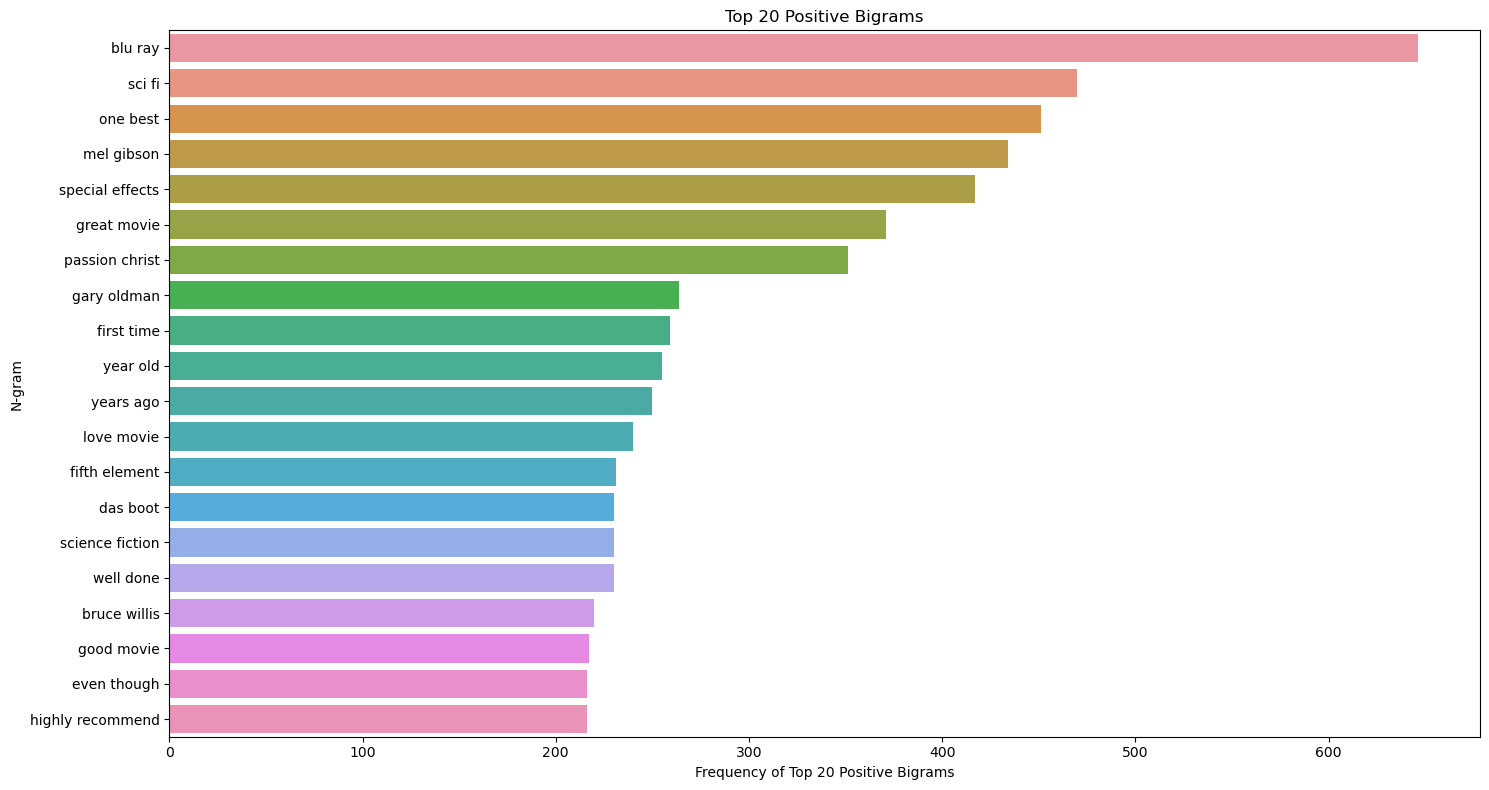

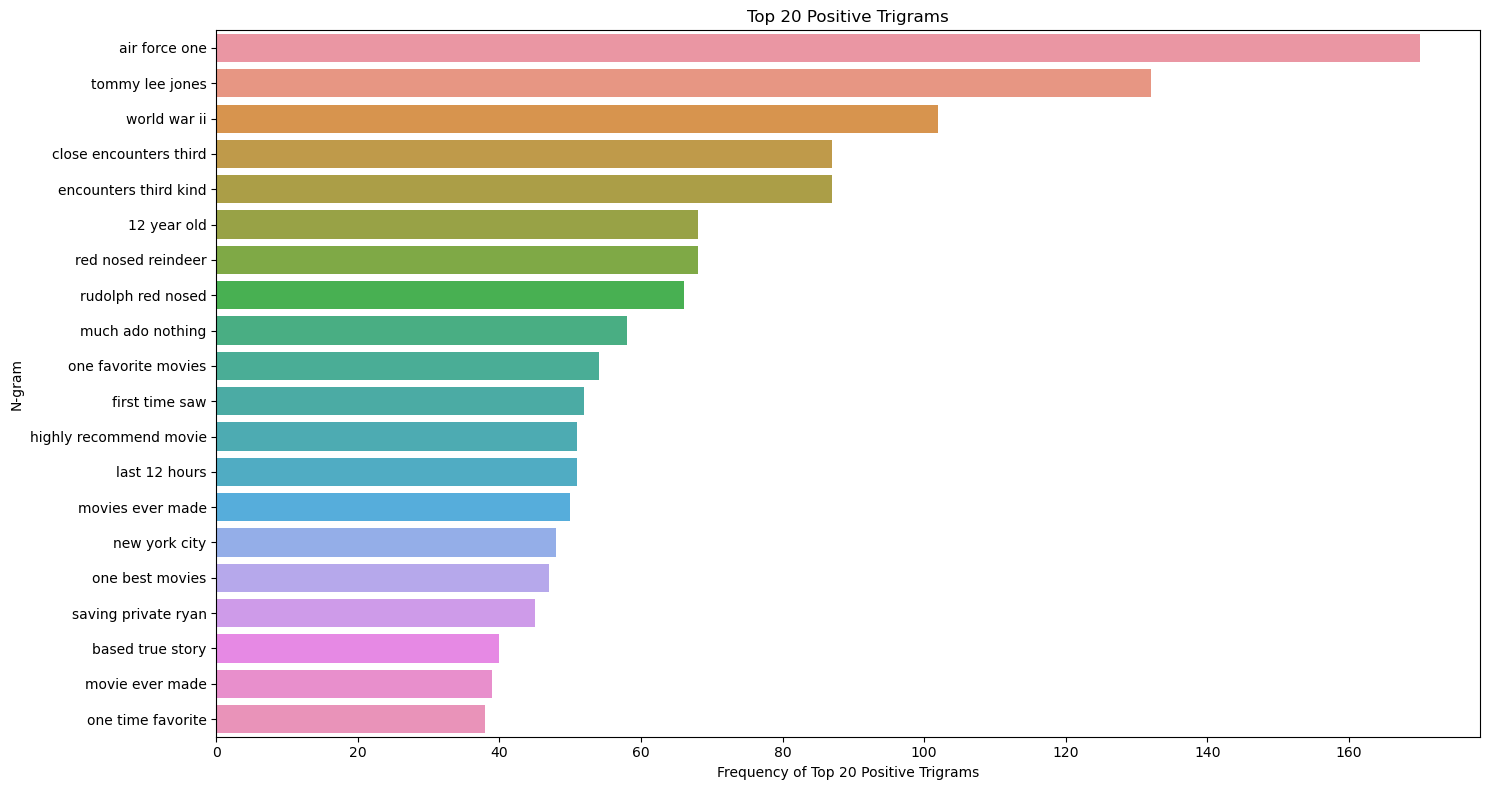

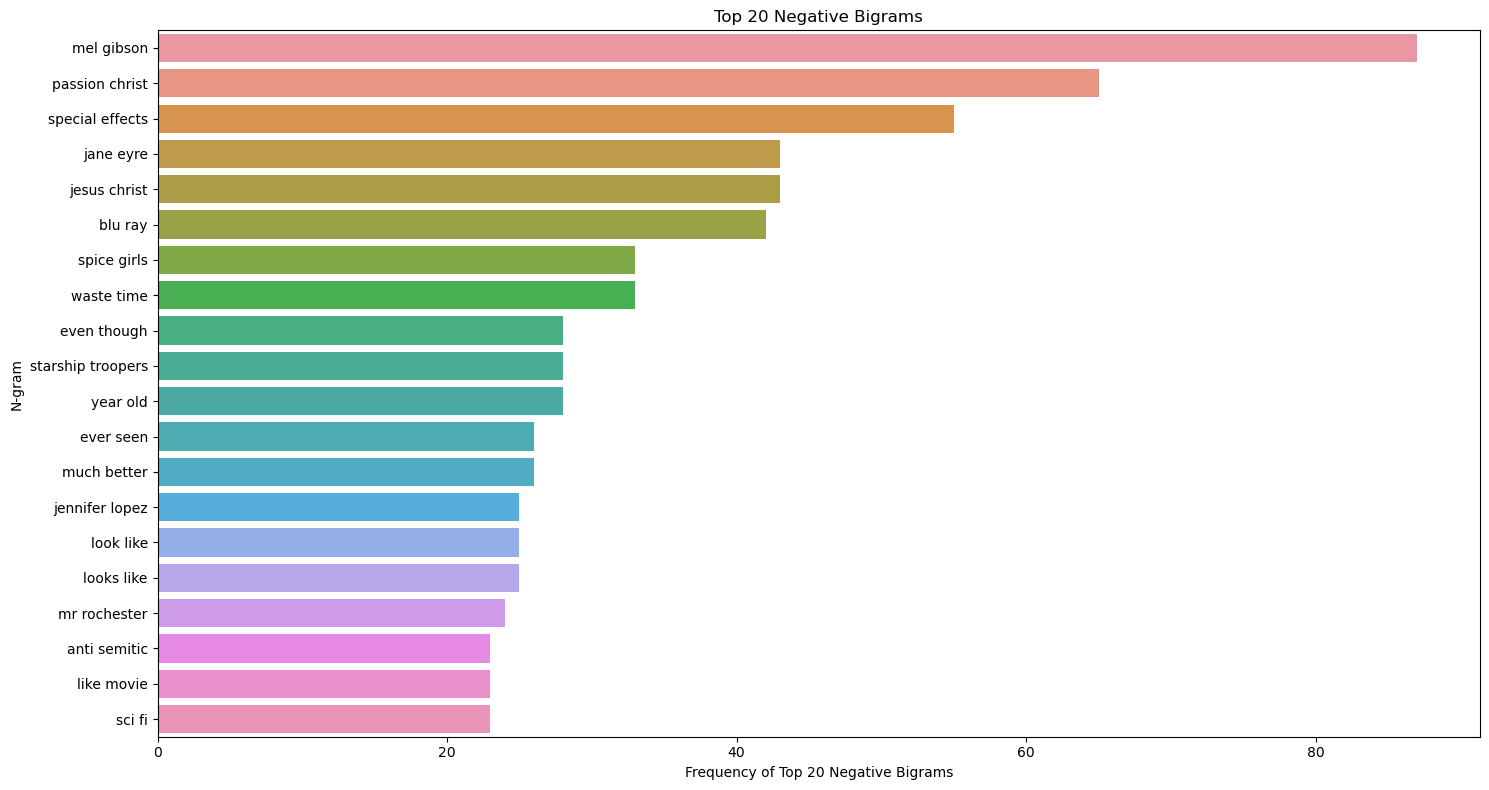

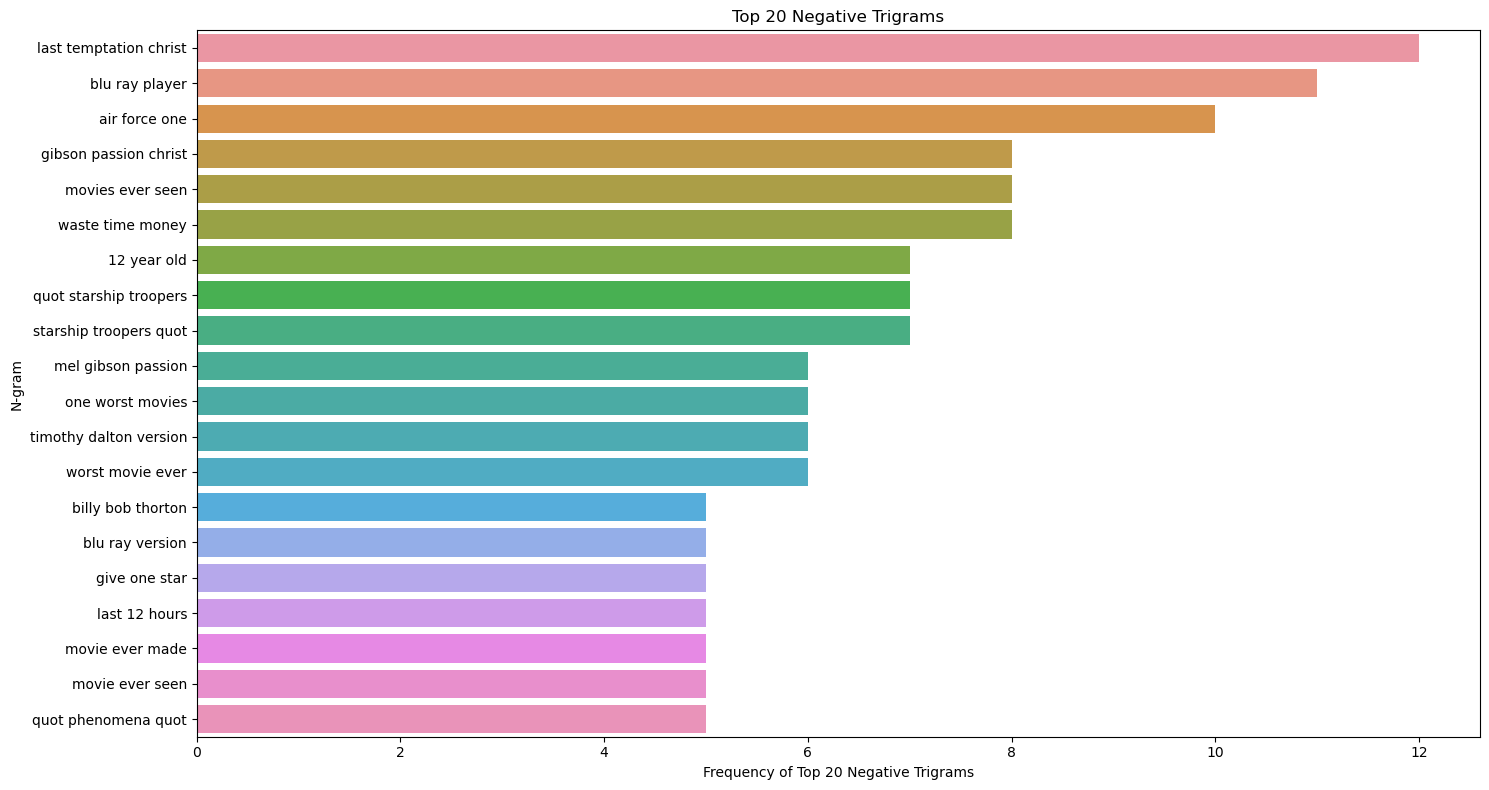

In [28]:
#Store positive reviews and negative reviews
positive_reviews = [review for review in short_movies_tv[short_movies_tv['overall'] > 3]['reviewText']]
negative_reviews = [review for review in short_movies_tv[short_movies_tv['overall'] < 3]['reviewText']]

#Define function to get the top ngrams in passed in review category
def get_top_ngrams(reviewType, topBlank, ngramType):
    #Create a CountVectorizer with specified range and stop words
    vectorizer = CountVectorizer(ngram_range = ngramType, stop_words = stopwords.words('english'))
    
    #Transform the review type into a document-term matrix
    tkcount = vectorizer.fit_transform(reviewType)
    
    #Get ngrams and their frequencies
    feature_names = vectorizer.get_feature_names_out()
    counts_sum = tkcount.sum(axis = 0).tolist()[0]
    
    #Combine ngrams and frequencies into a list of nested tuples
    ngram_freq = list(zip(feature_names, counts_sum))
    
    #Sort the list of nested tuples by frequencies
    ngram_freq_sorted = sorted(ngram_freq, key=lambda x: x[1], reverse=True)
    
    #Return the top ngrams as specified in passed in topBlank
    return ngram_freq_sorted[:topBlank]

#Get top 20 bigrams and trigrams for positive reviews
top_positive_bigrams = get_top_ngrams(positive_reviews, 20, (2, 2))
top_positive_trigrams = get_top_ngrams(positive_reviews, 20, (3, 3))

#Get top 20 bigrams and trigrams for negative reviews
top_negative_bigrams = get_top_ngrams(negative_reviews, 20, (2, 2))
top_negative_trigrams = get_top_ngrams(negative_reviews, 20, (3, 3))

# Combine all the ngrams into a list
all_ngram = [top_positive_bigrams, top_positive_trigrams, top_negative_bigrams, top_negative_trigrams]

#Create title list
title = ['Top 20 Positive Bigrams', 'Top 20 Positive Trigrams', 'Top 20 Negative Bigrams', 'Top 20 Negative Trigrams']

#Loop through the list of ngrams and create bar plots for each category
for ngrams, title in zip(all_ngram, title):
    plt.figure(figsize=(15, 8))
    sns.barplot(x = [count for i, count in ngrams], y = [ngram for ngram, _ in ngrams])
    plt.title(title)
    plt.xlabel(f'Frequency of {title}')
    plt.ylabel('N-gram')
    plt.tight_layout()
    plt.show()

Of the most frequent positive bigrams, we can see that there are specific actors, movies and characters that appear in frequently in positive reviews. Along with this, we can see positive expressions are fairly frequent as expected. We see the same traits and characteristics with the other n-grams both positive and negative, but through the negative n-grams, instead of positive expressions we see negative. The notable difference between the bigrams and trigrams are the more specific expressions, yet we see the same trend with frequent nouns.

First we must examine the sentences in which the significant adjectives are used, through these sentences, we can pinpoint the context in which the aspects of what drives positive/negative reviews to appear. From this point, we can examine informative words through examining the most frequent n-grams that appear in sentences where the word good is apparent. The larger the n-gram n value, the lesser we are to expect that our informative words are apparent near our significant adjectives. Though the examination of these frequent n-grams, we can note some factors that drive positive reviews.

In [29]:
#Define function to get adjective noun pairs
def getPairs(analysisString):
    #Initialize empty list to store the adjective noun pairs
    pairs = []
    
    #Tokenize passed in string into sentences
    strSentences = nltk.sent_tokenize(analysisString)
    
    #Loop through each sentence
    for indivSentence in strSentences:
        #Tokenize each word in the iteration sentence and assign them a POS Tag
        wordInSent = nltk.word_tokenize(indivSentence)
        assignTag = nltk.pos_tag(wordInSent)
        
        #Loop through each word in the iteration sentence
        for i in range(len(assignTag) - 1):
            #Ensure the adjective is one less than the end of the sentence
            if (i + 1 < len(assignTag)):
                #Extract both the current iteration word and tag
                cWord, cTag = assignTag[i]
                
                #If the iteration word tag is an adjective
                if cTag.startswith('JJ'):
                    #Create a sublist starting from the next word in the sentence to the end of the sentence
                    sublist = assignTag[i + 1:]
                    
                    #Loop through each word after the adjective
                    for subWord, subTag in sublist:
                        #If the word tag is a noun or a plural noun
                        if subTag.startswith(('NN', 'NNS', 'NNP', 'NNPS')):
                            #Add to the list both the adjective and following noun
                            pairs.append(f"{cWord} {subWord}")
                            #Break to avoid more than one noun per adjective
                            break
        
    #Return list of pairs
    return pairs

#Get the first review in short movies dataframe
first_review = short_movies_tv['reviewText'].iloc[0]
#Store the list of adjective noun pairs and print
result = getPairs(first_review)
print(result)

#Get testing string to pass in
example_sentence = "The big black dog scared the red cat."
#Store the list of adjective noun pairs and print
result_example = getPairs(example_sentence)
print(result_example)

['charming version', 'classic Dicken', 'good showing', 'better average']
['big dog', 'black dog', 'red cat']
